# Natural Language Processing
## Project 2_6 Report

**Authors**:
- Santiago Rodrigo Patino - 486170
- Robert Karsten Strehlow - 371376
- Syed Ali Murad Tahir - 467775

---

In [ ]:
pip install circlify

In [ ]:
pip install nltk

In [ ]:
import string
import tarfile
import requests
from pathlib import Path
import codecs
import nltk
from zipfile import ZipFile
import tqdm
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, RepeatVector, Dense, Concatenate, Dot, Activation, Masking, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import circlify
nltk.download('punkt')
nltk.download('wordnet')


from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


## Task2: Pre-processing

In [ ]:
def download_data() -> None:
    """
    Downloads the Bulgarian-English Translation file into the 'data' folder in Google Drive
    """
    if Path('/content/drive/MyDrive/machine_translation/bg-en.tgz').is_file():
        print(f'File already downloaded. Skipping download...')
        return
    data = requests.get('https://www.statmt.org/europarl/v7/bg-en.tgz')
    with Path('/content/drive/MyDrive/machine_translation/bg-en.tgz') as f:
        f.parent.mkdir(exist_ok=True, parents=True)
        f.write_bytes(data.content)


def extract_data() -> None:
    """
    Extracts the .tgz file that was downloaded to the 'data' folder in Google Drive
    """
    if (
        Path('/content/drive/MyDrive/machine_translation/europarl-v7.bg-en.bg').is_file()
        or Path('/content/drive/MyDrive/machine_translation/europarl-v7.bg-en.en').is_file()
    ):
        print(f'Files already exist. Skipping extraction...')
        return
    with tarfile.open('/content/drive/MyDrive/machine_translation/bg-en.tgz') as f:
        f.extractall('/content/drive/MyDrive/machine_translation/')


def get_data_preprocessed(lower_case=True, remove_punctuation=True) -> (list, list):
    en_data = []
    bg_data = []
    with codecs.open('/content/drive/MyDrive/machine_translation/europarl-v7.bg-en.en', 'r', encoding='utf-8') as f:
        for line in f:
            en_data.append(line.lower() if lower_case else line)
            if remove_punctuation:
                en_data[-1] = en_data[-1].translate(str.maketrans('', '', string.punctuation))
            en_data[-1] = en_data[-1].replace('\n', '')  # Remove newline character from en_data
    with codecs.open('/content/drive/MyDrive/machine_translation/europarl-v7.bg-en.bg', 'r', encoding='utf-8') as f:
        for line in f:
            bg_data.append(line.lower() if lower_case else line)
            if remove_punctuation:
                bg_data[-1] = bg_data[-1].translate(str.maketrans('', '', string.punctuation))
            bg_data[-1] = bg_data[-1].replace('\n', '')  # Remove newline character from bg_data

    return en_data, bg_data


In [ ]:
download_data()
extract_data()
en_dat, bg_dat = get_data_preprocessed()

File already downloaded. Skipping download...
Files already exist. Skipping extraction...


In [ ]:
dataset = pd.DataFrame(np.column_stack([en_dat, bg_dat]),
                               columns=['english_data', 'bulgarian_data'])
dataset_stats = dataset.copy()

In [ ]:
# Example: Printing the first five examples
for i in range(5):
    print("Example", i+1, ":")
    print("Input:", en_dat[i])
    print("Target:", bg_dat[i])
    print()

Example 1 :
Input: membership of parliament see minutes
Target: състав на парламента вж протоколи

Example 2 :
Input: approval of minutes of previous sitting see minutes
Target: одобряване на протокола от предишното заседание вж протоколите

Example 3 :
Input: membership of parliament see minutes
Target: състав на парламента вж протоколи

Example 4 :
Input: verification of credentials see minutes
Target: проверка на пълномощията вж протоколи

Example 5 :
Input: documents received see minutes
Target: внасяне на документи вж протоколи



## Task 1: Data exploration

#### 1.1 Length Diference
##### 1.1.1 Character Difference

In [ ]:
dataset

,english_data,bulgarian_data
0,membership of parliament see minutes,състав на парламента вж протоколи
1,approval of minutes of previous sitting see mi...,одобряване на протокола от предишното заседани...
2,membership of parliament see minutes,състав на парламента вж протоколи
3,verification of credentials see minutes,проверка на пълномощията вж протоколи
4,documents received see minutes,внасяне на документи вж протоколи
...,...,...
406929,composition of committees and delegations see...,състав на комисиите и делегациите вж протокола
406930,agenda of the next sitting see minutes,дневен ред на следващото заседание вж протокола
406931,closure of the sitting,закриване на заседанието
406932,the sitting closed at 2225,the sitting closed at 2225


In [ ]:
#Number of sentences in the whole corpus:
dataset_stats = dataset_stats.replace('', np.nan)
print("Number of records: ", dataset_stats["english_data"].shape[0])
print("Number of not null english records: ", dataset_stats["english_data"].notna().sum())
print("Number of not null bulgarian records: ",dataset_stats["bulgarian_data"].notna().sum())

Number of records:  406934
Number of not null english records:  406874
Number of not null bulgarian records:  406877


In [ ]:
#Average number of words
c_words_eng = dataset["english_data"].apply(lambda x: len(x.split()))
c_words_bul = dataset["bulgarian_data"].apply(lambda x: len(x.split()))
dataset_stats["num_words_eng"] = c_words_eng
dataset_stats["num_words_bul"] = c_words_bul

print("The AVG number of words per sentence in English is: %2.1f" % c_words_eng.mean())
#dataset.head()
print("The AVG number of words per sentence in Bulgarian is: %2.1f" % c_words_bul.mean())

The AVG number of words per sentence in English is: 24.2
The AVG number of words per sentence in Bulgarian is: 22.8


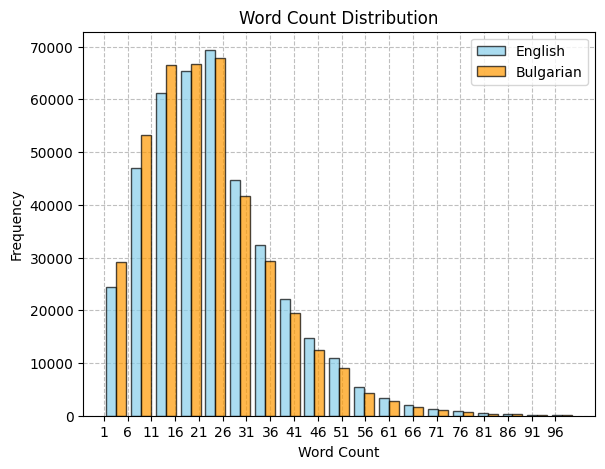

In [ ]:
plt.hist([c_words_eng, c_words_bul], bins=np.linspace(1, 100, 20), alpha=0.7, color=['skyblue', "#FF9900"], edgecolor='black')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.legend(['English', 'Bulgarian'])
plt.xticks(np.arange(1, 100, 5))

plt.grid(True, linestyle='--', alpha=0.8)
plt.gca().set_axisbelow(True)
plt.show()

In [ ]:
#Average number of characters
c_chars_eng = dataset["english_data"].apply(lambda x: len(x.replace(" ", "")))
c_chars_bul = dataset["bulgarian_data"].apply(lambda x: len(x.replace(" ", "")))
dataset_stats["num_chars_eng"] = c_chars_eng
dataset_stats["num_chars_bul"] = c_chars_bul

print("\nThe AVG number of characters per sentence in English is: %2.1f" % c_chars_eng.mean())
print("The AVG number of characters per sentence in Bulgarian is: %2.1f" % c_chars_bul.mean())


The AVG number of characters per sentence in English is: 119.6
The AVG number of characters per sentence in Bulgarian is: 125.8


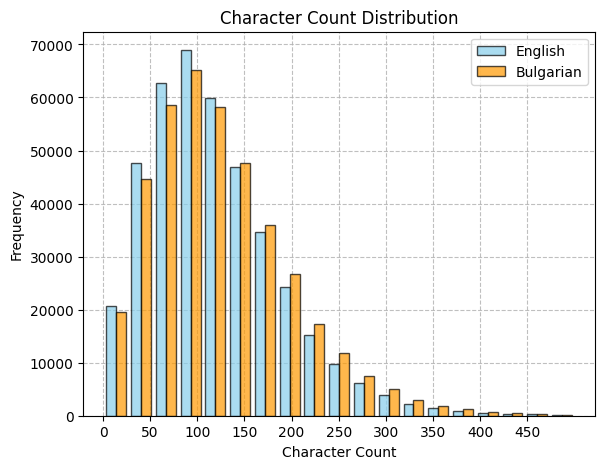

In [ ]:
plt.hist([c_chars_eng, c_chars_bul], bins=np.linspace(1, 500, 20), alpha=0.7, color=['skyblue', "#FF9900"], edgecolor='black')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Count Distribution')
plt.legend(['English', 'Bulgarian'])
plt.xticks(np.arange(0, 500, 50))

plt.grid(True, linestyle='--', alpha=0.8)
plt.gca().set_axisbelow(True)
plt.show()

In [ ]:
#Average length of each word

def len_words(text):
    word_array = text.split()
    total_words = len(word_array)
    return sum(len(word) for word in word_array) / len(word_array) if (total_words) > 0 else 0

len_words_eng = dataset["english_data"].apply(len_words)
len_words_bul = dataset["bulgarian_data"].apply(len_words)
dataset_stats["avg_len_words_eng"] = np.round(len_words_eng,2)
dataset_stats["avg_len_words_bul"] = np.round(len_words_bul,2)

print("\nThe AVG number of characters per word in English is: %2.1f" % len_words_eng.mean())
print("The AVG number of characters per word in Bulgarian is: %2.1f" % len_words_bul.mean())


The AVG number of characters per word in English is: 4.9
The AVG number of characters per word in Bulgarian is: 5.5


In [ ]:
dataset_stats

,english_data,bulgarian_data,num_words_eng,num_words_bul
0,membership of parliament see minutes,състав на парламента вж протоколи,5,5
1,approval of minutes of previous sitting see mi...,одобряване на протокола от предишното заседани...,8,8
2,membership of parliament see minutes,състав на парламента вж протоколи,5,5
3,verification of credentials see minutes,проверка на пълномощията вж протоколи,5,5
4,documents received see minutes,внасяне на документи вж протоколи,4,5
...,...,...,...,...
406929,composition of committees and delegations see...,състав на комисиите и делегациите вж протокола,7,7
406930,agenda of the next sitting see minutes,дневен ред на следващото заседание вж протокола,7,7
406931,closure of the sitting,закриване на заседанието,4,3
406932,the sitting closed at 2225,the sitting closed at 2225,5,5


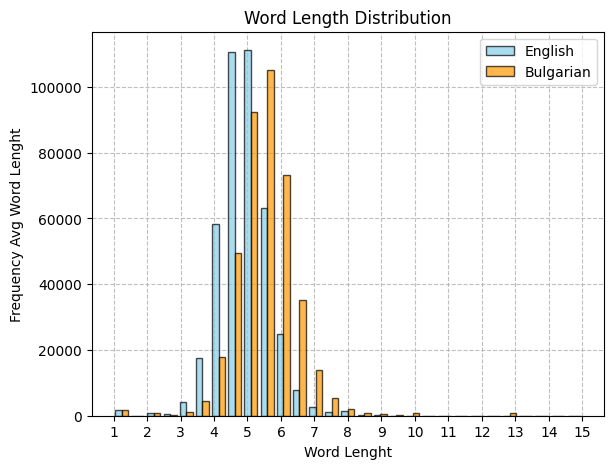

In [ ]:
plt.hist([len_words_eng, len_words_bul], bins=np.linspace(1, 15,30), alpha=0.7, color=['skyblue', "#FF9900"], edgecolor='black')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.xlabel('Word Lenght')
plt.ylabel('Frequency Avg Word Lenght')
plt.title('Word Length Distribution')
plt.legend(['English', 'Bulgarian'])
plt.xticks(np.arange(1, 16, 1))

plt.grid(True, linestyle='--', alpha=0.8)
plt.gca().set_axisbelow(True)
plt.show()

In [ ]:
def count_vowels_and_consonants(sentence):
    num_vowels, num_consonants = 0, 0
    for char in sentence:
        if char in vowels:
            num_vowels += 1
        elif char in consonants:
            num_consonants += 1

    return num_vowels, num_consonants

vowels= "aeiouAEIOU"
consonants= "bcdfghjklmnpqrstvwxyzBCDFGHJKLMNPQRSTVWXYZ"
vowel_cons_eng = dataset["english_data"].apply(count_vowels_and_consonants)
dataset_stats[["num_vowels_eng", "num_consonants_eng"]] = pd.DataFrame(vowel_cons_eng.tolist(), index=dataset.index)

vowels = "аъоуеиюяАЪОУЕИЮЯ"
consonants = "бвгджзйклмнпрстфхцчшщБВГДЖЗЙКЛМНПРСТФХЦЧШЩ"
vowel_cons_bul = dataset["bulgarian_data"].apply(count_vowels_and_consonants)
dataset_stats[["num_vowels_bul", "num_consonants_bul"]] = pd.DataFrame(vowel_cons_bul.tolist(), index=dataset.index)


#print("The AVG number of vowels and consonant per sentence in English is: %2.1f" % vowel_cons_eng.mean())
#print("The AVG number of vowels and consonant per sentence in Bulgarian is: %2.1f and %2.1f" % c_words_eng.mean(), c_words_eng.mean())

In [ ]:
print("The AVG number of vowels and consonants per sentence in English is: %2.1f" % dataset_stats["num_vowels_eng"].mean(), end=" ")
print("and %2.1f" % dataset_stats["num_consonants_eng"].mean())

print("The AVG number of vowels and consonants per sentence in Bulgarian is: %2.1f" % dataset_stats["num_vowels_bul"].mean(), end=" ")
print("and %2.1f" % dataset_stats["num_consonants_bul"].mean())

The AVG number of vowels and consonants per sentence in English is: 47.0 and 72.1
The AVG number of vowels and consonants per sentence in Bulgarian is: 55.3 and 69.2


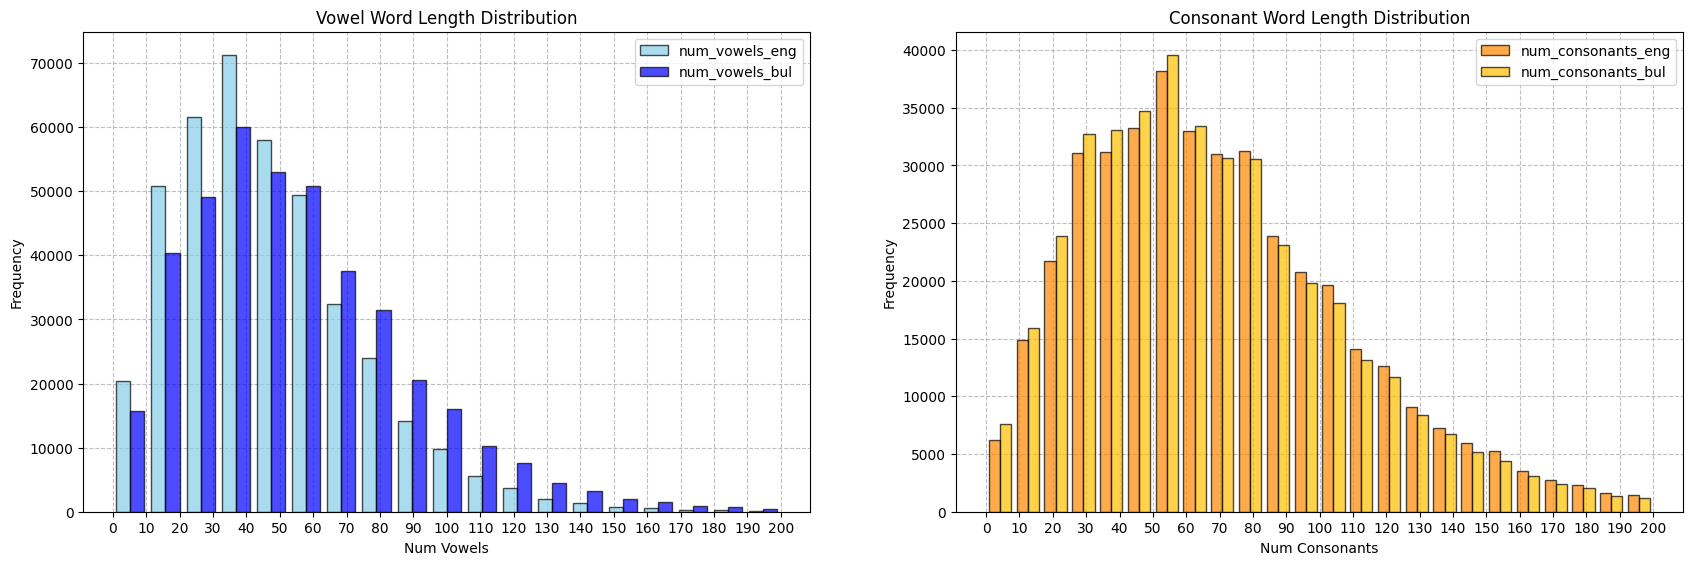

In [ ]:
# Subplot for vowels
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.hist(dataset_stats[["num_vowels_eng", "num_vowels_bul"]], bins=np.linspace(0, 200, 20), alpha=0.7, color=['skyblue', "blue"], edgecolor='black')
plt.xlabel('Num Vowels')
plt.ylabel('Frequency')
plt.title('Vowel Word Length Distribution')
plt.legend(["num_vowels_eng", "num_vowels_bul"])
plt.xticks(np.arange(0, 210, 10))
plt.grid(True, linestyle='--', alpha=0.8)
plt.gca().set_axisbelow(True)

# Subplot for consonants
plt.subplot(1, 2, 2)
plt.hist(dataset_stats[["num_consonants_eng", "num_consonants_bul"]], bins=np.linspace(0, 200, 25), alpha=0.7, color=['#FF8800', '#FFBF00'], edgecolor='black')
plt.xlabel('Num Consonants')
plt.ylabel('Frequency')
plt.title('Consonant Word Length Distribution')
plt.legend(["num_consonants_eng", "num_consonants_bul"])
plt.xticks(np.arange(0, 210, 10))
plt.grid(True, linestyle='--', alpha=0.8)
plt.gca().set_axisbelow(True)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

#### Summary

In [ ]:
print("The AVG number of words per sentence in English is: %2.1f" % c_words_eng.mean())
print("The AVG number of words per sentence in Bulgarian is: %2.1f" % c_words_bul.mean())
print("\nThe AVG number of characters per sentence in English is: %2.1f" % c_chars_eng.mean())
print("The AVG number of characters per sentence in Bulgarian is: %2.1f" % c_chars_eng.mean())
print("\nThe AVG number of characters per word in English is: %2.1f" % len_words_eng.mean())
print("The AVG number of characters per word in Bulgarian is: %2.1f" % len_words_bul.mean())
print("\nThe AVG number of vowels and consonants per sentence in English is: %2.1f" % dataset_stats["num_vowels_eng"].mean(), end=" ")
print("and %2.1f" % dataset_stats["num_consonants_eng"].mean())
print("The AVG number of vowels and consonants per sentence in Bulgarian is: %2.1f" % dataset_stats["num_vowels_bul"].mean(), end=" ")
print("and %2.1f" % dataset_stats["num_consonants_bul"].mean())



The AVG number of words per sentence in English is: 24.2
The AVG number of words per sentence in Bulgarian is: 22.8

The AVG number of characters per sentence in English is: 119.6
The AVG number of characters per sentence in Bulgarian is: 119.6

The AVG number of characters per word in English is: 4.9
The AVG number of characters per word in Bulgarian is: 5.5

The AVG number of vowels per sentence in English is: 47.0 and 72.1
The AVG number of vowels per sentence in Bulgarian is: 55.3 and 69.2


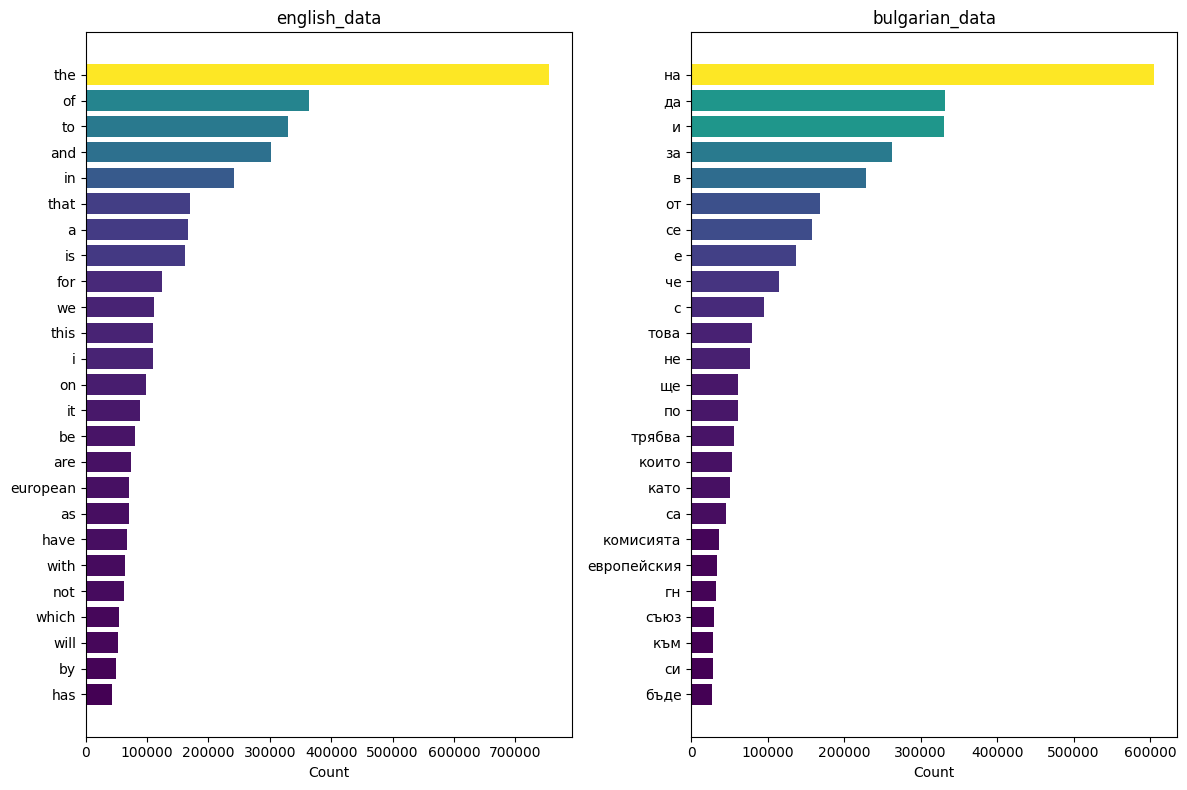

In [ ]:
#bar chart frequency of words

def plot_word_frequency(dataset, top=20):
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.6)
    columns = ['english_data', 'bulgarian_data']

    for i, ax in enumerate(axes.flatten()):
        words_list = dataset[columns[i]].str.split().tolist()
        words_flat = [word for sublist in words_list for word in sublist]
        word_counts = Counter(words_flat)
        labels, values = zip(*word_counts.items())
        sorted_indices = np.argsort(values)[::-1]
        sorted_labels = np.array(labels)[sorted_indices][:top][::-1]  # Sort labels in inverted order
        sorted_values = np.array(values)[sorted_indices][:top][::-1]  # Sort values in inverted order
        color_map = plt.get_cmap('viridis')

        norm_values = (sorted_values - min(sorted_values)) / (max(sorted_values) - min(sorted_values))

        ax.barh(range(len(sorted_labels)), sorted_values, color=color_map(norm_values))
        ax.set_yticks(range(len(sorted_labels)))
        ax.set_yticklabels(sorted_labels)
        ax.set_xlabel('Count')
        ax.set_title(columns[i])

    plt.tight_layout()
    plt.show()

plot_word_frequency(dataset, top=25)


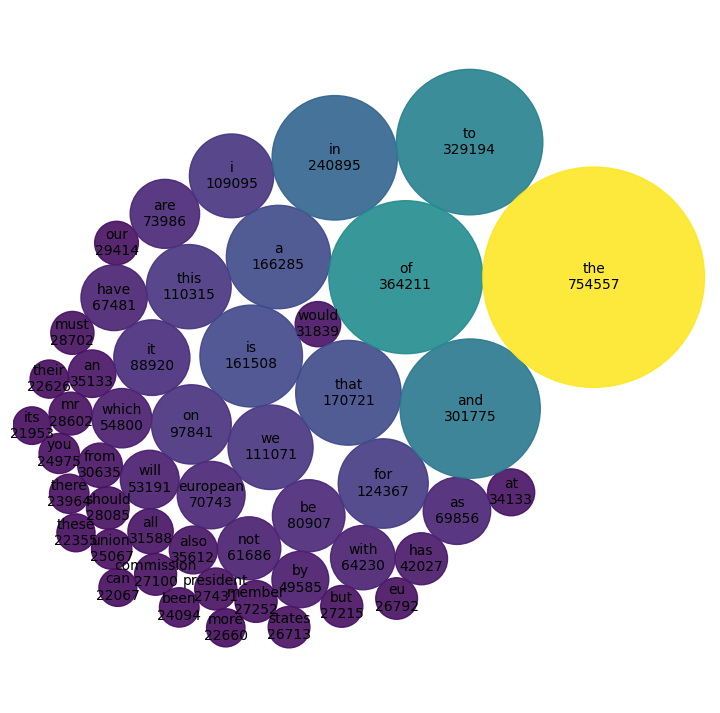

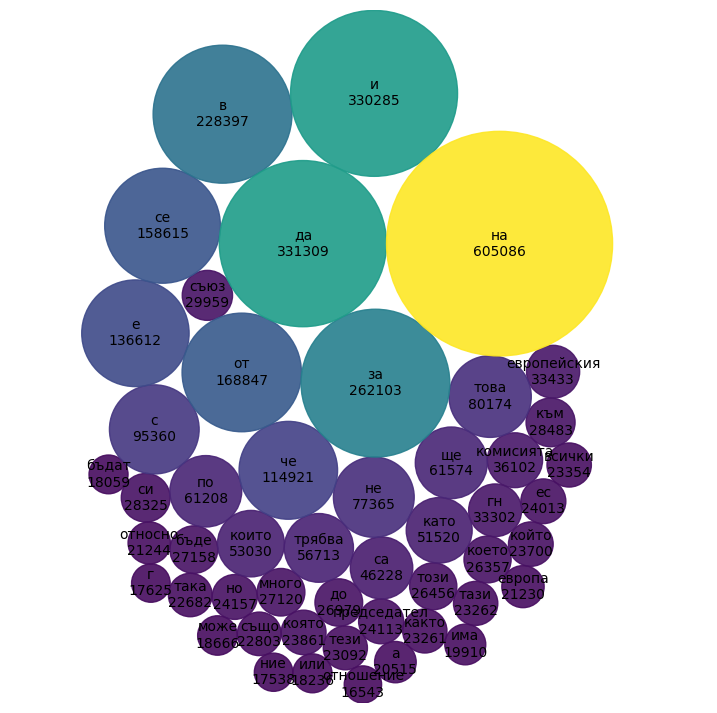

In [ ]:
def plot_word_frequency_circles(words, top=20):
    # We sort the word counts in descending order
    word_counts = Counter(words)
    sorted_counts = sorted(word_counts.values(), reverse=True)
    sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)

    # Create the circles
    circles = circlify.circlify(sorted_counts[:top], show_enclosure=False, target_enclosure=circlify.Circle(x=0, y=0))
    n = sorted_counts[0]

    # Plot the circles we have created
    fig, ax = plt.subplots(figsize=(9, 9), facecolor='white')
    ax.axis('off')
    lim = max(max(abs(circle.x) + circle.r, abs(circle.y) + circle.r) for circle in circles)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    labels = sorted_words[:top]
    counts = sorted_counts[:top]
    labels.reverse()
    counts.reverse()

    color_map = plt.get_cmap('viridis')

    # Plot the circles
    for circle, label, count in zip(circles, labels, counts):
        x, y, r = circle
        color = color_map(count / n)
        ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color=color))
        plt.annotate(label + '\n' + str(count), (x, y), size=10, va='center', ha='center')

    plt.xticks([])
    plt.yticks([])
    plt.show()

words_english = dataset['english_data'].str.split().tolist()
words_bulgarian = dataset['bulgarian_data'].str.split().tolist()

# Flatten the lists to get individual words for English and Bulgarian data
flattened_list_english = [word for sublist in words_english for word in sublist]
flattened_list_bulgarian = [word for sublist in words_bulgarian for word in sublist]

# Plot word frequency circles for English data
plot_word_frequency_circles(flattened_list_english, top=50)

# Plot word frequency circles for Bulgarian data
plot_word_frequency_circles(flattened_list_bulgarian, top=50)

## Task 3: Neural Machine Translation

<font color=red>**Before starting training our mode, we reduce the size of the dataset as you need A100 GPU to train the model and even
then RAM needed is over 40GB. Hence, we use 50% of data**</font>



In [ ]:
def data_size(en_data, bg_data, percentage=0.5):
    total_data = int(len(en_data) * percentage)
    en_data = en_data[:total_data]
    bg_data = bg_data[:total_data]
    return en_data, bg_data


en_dat, bg_dat = data_size(en_dat, bg_dat, 0.5)
print(len(en_dat))


203467


#### **Padding & Tokenization**

In [ ]:
def tokenize_and_pad_sequences(eng_data, bg_data, max_length=None, num_words=None):
    """
    Tokenizes and pads the English and Bulgarian data.

    Args:
    eng_data (list): List of English sentences
    bg_data (list): List of Bulgarian sentences
    max_length (int): The maximum length of the sentence
    num_words (int): The maximum number of words to keep, based on word frequency

    Returns:
    encoder_padded (list): List of padded English sentences
    decoder_padded (list): List of padded Bulgarian sentences
    max_length (int): The maximum length of the sentence
    tokenizer_eng (Tokenizer): Tokenizer for English sentences
    tokenizer_bg (Tokenizer): Tokenizer for Bulgarian sentences
    """

    # Tokenize the English data
    #tokenizer_eng = Tokenizer(num_words=num_words, oov_token='<OOV>')
    tokenizer_eng = Tokenizer(filters='')
    tokenizer_eng.fit_on_texts(eng_data)
    encoder_sequence = tokenizer_eng.texts_to_sequences(eng_data)

    # Tokenize the Bulgarian data
    #tokenizer_bg = Tokenizer(num_words=num_words, oov_token='<OOV>')
    tokenizer_bg = Tokenizer(filters='')
    tokenizer_bg.fit_on_texts(bg_data)
    decoder_sequence = tokenizer_bg.texts_to_sequences(bg_data)

    # Determine max length of encoder and decoder sequences - Select the max length between them
    if max_length is None:
        max_length = max(max(len(seq) for seq in encoder_sequence), max(len(seq) for seq in decoder_sequence))

    # Pad the encoder and decoder sequences
    encoder_padded = pad_sequences(encoder_sequence, maxlen=max_length, padding='post')
    decoder_padded = pad_sequences(decoder_sequence, maxlen=max_length, padding='post')

    return encoder_padded, decoder_padded, max_length, tokenizer_eng, tokenizer_bg


def vocabulary_size(tokenizer):
  vocab_size = len(tokenizer.word_index) + 1
  return vocab_size


In [ ]:
max_len = 25

encoder_padded, decoder_padded, max_length, tokenizer_input, tokenizer_target= tokenize_and_pad_sequences(en_dat, bg_dat, max_length=max_len)

In [ ]:
eng_vocab_size = vocabulary_size(tokenizer_input)
bul_vocab_size = vocabulary_size(tokenizer_target)

print(f"English Vocab size: {eng_vocab_size}")
print(f"Bulgarian Vocab size: {bul_vocab_size}")

English Vocab size: 38940
Bulgarian Vocab size: 77638


In [ ]:
print(f"Encoder padded: {encoder_padded[25]}")
print(f"Tokenizer input Index: {tokenizer_input.word_index}")

Encoder padded: [   1  457   48 2138   27 1524 1917    4 2493   27 1907 1917    0    0
    0    0    0    0    0    0    0    0    0    0    0]
Tokenizer input Index: {'the': 1, 'of': 2, 'to': 3, 'and': 4, 'in': 5, 'that': 6, 'a': 7, 'is': 8, 'for': 9, 'we': 10, 'this': 11, 'i': 12, 'on': 13, 'it': 14, 'be': 15, 'are': 16, 'have': 17, 'as': 18, 'european': 19, 'not': 20, 'with': 21, 'will': 22, 'which': 23, 'by': 24, 'has': 25, 'also': 26, 'at': 27, 'an': 28, 'would': 29, 'all': 30, 'our': 31, 'mr': 32, 'from': 33, 'president': 34, 'but': 35, 'commission': 36, 'you': 37, 'must': 38, 'should': 39, 'member': 40, 'states': 41, 'there': 42, 'been': 43, 'union': 44, 'can': 45, 'their': 46, 'parliament': 47, 'was': 48, 'more': 49, 'these': 50, 'eu': 51, 'like': 52, 'very': 53, 'they': 54, 'its': 55, 'or': 56, 'do': 57, 'report': 58, 'europe': 59, 'need': 60, 'one': 61, 'what': 62, 'us': 63, 'important': 64, 'so': 65, 'countries': 66, 'my': 67, 'about': 68, 'who': 69, 'council': 70, 'if': 71,

#### **Word Embedding**

<font color=red>**Utilized pre-trained word embeddings: Glove Embedding (Stanford) for English and FastText Word2Vec for Bulgarian**</font>



In [ ]:
def import_glove_embedding():
    """
    Downloads and unzips the GloVe embeddings.
    """

    # Set the path for the GloVe embeddings file
    embedding_path = Path('/content/drive/MyDrive/glove_embedding/glove.6B.300d.txt')

    # Check if the embeddings file already exists in the target directory
    if embedding_path.is_file():
        print('File already downloaded. Skipping download...')
        return

    # Create the directory for GloVe embeddings if it doesn't exist
    embedding_dir = '/content/drive/MyDrive/glove_embedding/'
    os.makedirs(embedding_dir, exist_ok=True)

    print('Downloading GloVe embeddings...')
    glove_url = f'https://nlp.stanford.edu/data/glove.6B.zip'
    glove_zip_path = Path(embedding_dir) / f'glove.6B.zip'

    # Download the GloVe embeddings zip file
    data = requests.get(glove_url)
    with open(glove_zip_path, 'wb') as f:
        f.write(data.content)

    # Unzip the downloaded file
    with ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall(embedding_dir)

    # Clean up: Remove the downloaded zip file (optional)
    # os.remove(glove_zip_path)




import os
from pathlib import Path

def import_bulgarian_embedding():
    """
    Downloads and unzips the Bulgarian FastText embeddings.
    """

    # Set the path for the Bulgarian FastText embeddings file
    embedding_path = Path('/content/drive/MyDrive/bulgarian_embedding/cc.bg.300.vec')

    # Check if the embeddings file already exists in the target directory
    if embedding_path.is_file():
        print('File already downloaded. Skipping download...')
        return

    # Create the directory for Bulgarian FastText embeddings if it doesn't exist
    embedding_dir = '/content/drive/MyDrive/bulgarian_embedding/'
    os.makedirs(embedding_dir, exist_ok=True)

    print('Downloading Bulgarian FastText embeddings...')
    !wget -P {embedding_dir} https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bg.300.vec.gz

    # Extract the downloaded embeddings
    print('Extracting Bulgarian FastText embeddings...')
    !gunzip {embedding_dir}cc.bg.300.vec.gz

    print('File Successfully downloaded and extracted')


In [ ]:
import_glove_embedding()

File already downloaded. Skipping download...


In [ ]:
import_bulgarian_embedding()

--2023-07-27 23:39:30--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bg.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.248.22, 65.8.248.107, 65.8.248.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.248.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216996308 (1.1G) [binary/octet-stream]
Saving to: ‘/content/drive/MyDrive/bulgarian_embedding/cc.bg.300.vec.gz’

cc.bg.300.vec.gz    100%[===================>]   1.13G  26.3MB/s    in 38s     

2023-07-27 23:40:09 (30.6 MB/s) - ‘/content/drive/MyDrive/bulgarian_embedding/cc.bg.300.vec.gz’ saved [1216996308/1216996308]

Extracting Bulgarian FastText embeddings...
File Successfully downloaded and extracted


In [68]:
#Create dictionary for english words
eng_embeddings_dict = dict()
glove_file = open('/content/drive/MyDrive/glove_embedding/glove.6B.300d.txt', 'r', encoding='utf-8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dim = np.asarray(records[1:], dtype='float32')
    eng_embeddings_dict[word] = vector_dim

In [ ]:
#Create dictionary for bulgarian words
bg_embeddings_dict = dict()
bg_file = open('/content/drive/MyDrive/bulgarian_embedding/cc.bg.300.vec', encoding='utf-8')

for line in bg_file:
    records = line.strip().split()
    word = records[0]
    vector_dim = np.asarray(records[1:], dtype='float32')
    bg_embeddings_dict[word] = vector_dim

bg_file.close()

In [ ]:
bg_embeddings_dict['избран']

array([ 0.0082,  0.0246, -0.0002,  0.0858, -0.0053,  0.0111,  0.0248,
        0.0625,  0.0363, -0.0414, -0.0251,  0.0161, -0.0227, -0.0452,
       -0.0059,  0.0385, -0.0011, -0.0006,  0.0325, -0.0035, -0.0199,
       -0.0392, -0.0383,  0.0464, -0.081 ,  0.0294,  0.0009,  0.0049,
       -0.0163,  0.105 , -0.0026,  0.0239, -0.0348,  0.0337, -0.0287,
        0.0552, -0.0595, -0.0246, -0.0025,  0.055 ,  0.0093,  0.0445,
       -0.0086,  0.0131, -0.0236,  0.0303, -0.0315, -0.0465,  0.1072,
       -0.0877,  0.0223,  0.0528,  0.0049, -0.074 , -0.0278,  0.0336,
        0.0131,  0.0704,  0.0929,  0.025 ,  0.0433, -0.0166,  0.0126,
       -0.0311, -0.0007,  0.0227,  0.1229, -0.0269,  0.0495, -0.0222,
        0.015 , -0.0029, -0.0188, -0.0709,  0.0042, -0.0192, -0.0459,
       -0.001 ,  0.0468, -0.011 , -0.0096, -0.0384, -0.0382,  0.0812,
        0.0376, -0.036 , -0.0093,  0.0025,  0.0658,  0.0608,  0.0378,
        0.0448, -0.0242, -0.0052,  0.0451, -0.1058,  0.0624, -0.0771,
        0.0426,  0.0

In [ ]:
def word_embedding(embeddings_dict_english, embedding_dic_bulg, tokenizer_input, tokenizer_target, embedding_dim=300):

    eng_vocab_size = len(tokenizer_input.word_index) + 1
    bg_vocab_size = len(tokenizer_target.word_index) + 1

    encoder_embedding_matrix = np.zeros((eng_vocab_size, embedding_dim))
    decoder_embedding_matrix = np.zeros((bg_vocab_size, embedding_dim))

    for word, index in tokenizer_input.word_index.items():
        vector = embeddings_dict_english.get(word)
        if vector is not None:
            encoder_embedding_matrix[index] = vector

    for word, index in tokenizer_target.word_index.items():
        vector = embedding_dic_bulg.get(word)
        if vector is not None:
            decoder_embedding_matrix[index] = vector

    return encoder_embedding_matrix, decoder_embedding_matrix

In [ ]:
encoder_embedding_matrix, decoder_embedding_matrix = word_embedding(eng_embeddings_dict, bg_embeddings_dict, tokenizer_input, tokenizer_target, embedding_dim=300)

#### **Train_Test Split**

In [ ]:
# Splitting the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(encoder_padded, decoder_padded, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#### **RNN-based sequence-to-sequence model**

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, RepeatVector, Dense



def seq2seq_model(input_vocab_size, output_vocab_size, encoder_embedding_matrix, decoder_embedding_matrix, embedding_dim=300, max_length=25, hidden_units=128, change_targets=False):

  #Translate from bulgarian to English
  if change_targets:
    # Encoder
    encoder_inputs = Input(shape=(max_length,))
    encoder_embedding = Embedding(output_vocab_size, embedding_dim, weights=[decoder_embedding_matrix], input_length=max_length, mask_zero=True)(encoder_inputs)
    encoder_lstm = LSTM(hidden_units)(encoder_embedding)

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(input_vocab_size, embedding_dim, weights=[encoder_embedding_matrix])(decoder_inputs)
    decoder_lstm = LSTM(hidden_units, return_sequences=True)(decoder_embedding)
    decoder_outputs = Dense(input_vocab_size, activation='softmax')(decoder_lstm)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  #Translate from English to Bulgarian
  else:
    # Encoder
    encoder_inputs = Input(shape=(max_length,))
    encoder_embedding = Embedding(input_vocab_size, embedding_dim, weights=[encoder_embedding_matrix], input_length=max_length, mask_zero=True)(encoder_inputs)
    encoder_lstm = LSTM(hidden_units)(encoder_embedding)

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, embedding_dim, weights=[decoder_embedding_matrix])(decoder_inputs)
    decoder_lstm = LSTM(hidden_units, return_sequences=True)(decoder_embedding)
    decoder_outputs = Dense(output_vocab_size, activation='softmax')(decoder_lstm)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  return model


#### **Evaluation of Seq2Seq Model**


#####<font color='blue'> 1) Seq2Seq model with glove embedding and max_length = 25 </font>

###### **Model Build**

In [ ]:
def model_build(model_store_path, eng_vocab_size, bul_vocab_size, encoder_embedding_matrix, decoder_embedding_matrix,
                embed_dim=300, max_len=25, hid_unit=128, change_target=False):

  # Set up early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

  # Set up model checkpoint callback to save the best model
  model_checkpoint = ModelCheckpoint(filepath=model_store_path, monitor='val_loss', save_best_only=True)
  model = seq2seq_model(eng_vocab_size, bul_vocab_size, encoder_embedding_matrix, decoder_embedding_matrix, embedding_dim=embed_dim, max_length=max_len, hidden_units=hid_unit, change_targets=change_target)

  model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'],


            )

  model.summary()

  return model, early_stopping, model_checkpoint


#Build Model
model_path = '/content/drive/MyDrive/machine_translation_models/seq2seq_glove_25.h5'
model, early_stopping, model_checkpoint = model_build(model_path, eng_vocab_size, bul_vocab_size, encoder_embedding_matrix, decoder_embedding_matrix,
                embed_dim=300, max_len=25, hid_unit=128, change_target=False)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, None, 300)    23291400    ['input_10[0][0]']               
                                                                                                  
 lstm_9 (LSTM)                  (None, None, 128)    219648      ['embedding_9[0][0]']            
                                                                                                  
 input_9 (InputLayer)           [(None, 25)]         0           []                               
                                                                                            

###### **Model Train**

In [ ]:
history = model.fit([X_train, y_train[:, :-1]], y_train[:, 1:], batch_size=64, epochs=20, validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]), callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
2289/2289 [==============================] - 128s 55ms/step - loss: 5.0333 - accuracy: 0.3447 - val_loss: 4.3802 - val_accuracy: 0.3969
Epoch 2/20
2289/2289 [==============================] - 107s 47ms/step - loss: 4.0580 - accuracy: 0.4204 - val_loss: 3.9215 - val_accuracy: 0.4326
Epoch 3/20
2289/2289 [==============================] - 105s 46ms/step - loss: 3.6861 - accuracy: 0.4474 - val_loss: 3.7424 - val_accuracy: 0.4464
Epoch 4/20
2289/2289 [==============================] - 104s 45ms/step - loss: 3.4709 - accuracy: 0.4626 - val_loss: 3.6555 - val_accuracy: 0.4538
Epoch 5/20
2289/2289 [==============================] - 103s 45ms/step - loss: 3.3174 - accuracy: 0.4731 - val_loss: 3.6131 - val_accuracy: 0.4584
Epoch 6/20
2289/2289 [==============================] - 103s 45ms/step - loss: 3.1964 - accuracy: 0.4817 - val_loss: 3.5953 - val_accuracy: 0.4611
Epoch 7/20
2289/2289 [==============================] - 104s 45ms/step - loss: 3.0954 - accuracy: 0.4892 - val_loss: 3

###### **Model Evaluate**

In [ ]:
def analyze_results_model(model_results):
    train_loss = model_results.history['loss']
    val_loss = model_results.history['val_loss']
    train_accuracy = model_results.history['accuracy']
    val_accuracy = model_results.history['val_accuracy']


    epochs = range(1, len(train_loss) + 1)

    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot loss scores
    axs[0].plot(epochs, train_loss, 'g', label='Training Loss')
    axs[0].plot(epochs, val_loss, 'b', label='Validation Loss')
    axs[0].set_title('Loss Scores')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot accuracy scores
    axs[1].plot(epochs, train_accuracy, 'c', label='Training Accuracy')
    axs[1].plot(epochs, val_accuracy, 'm', label='Validation Accuracy')
    axs[1].set_title('Accuracy Scores')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Show the plots
    plt.show()

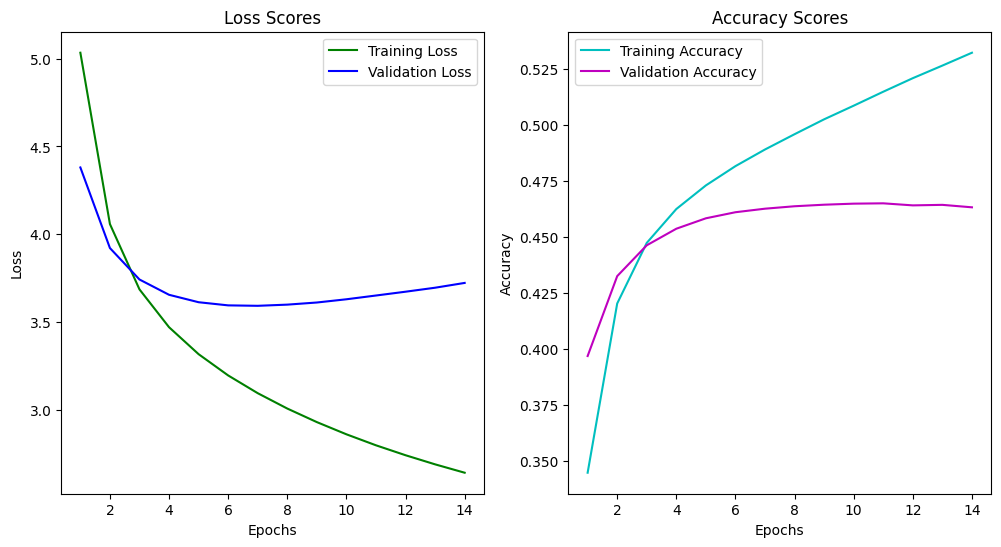

In [ ]:
analyze_results_model(history)

In [ ]:
# load a saved model
from keras.models import load_model
seq2seq_glove_25 = load_model('/content/drive/MyDrive/machine_translation_models/seq2seq_glove_25.h5')

In [47]:
results = seq2seq_glove_25.evaluate([X_test, y_test[:, :-1]], y_test[:, 1:], batch_size=64)
print(results)

636/636 [==============================] - 23s 36ms/step - loss: 3.5817 - accuracy: 0.4664
[3.581735134124756, 0.46642419695854187]


**1)First represents the evaluation loss on the test dataset.<br>**
**2) Second value represents the evaluation metric (accuracy) on the test dataset. In our case, it's approximately 46.6%.<br><br>**

**The evaluation loss measures how well the model's predictions match the ground truth translations in terms of the model's loss function (sparse categorical cross-entropy in your case). The evaluation metric (accuracy) measures how many of the predicted translations exactly match the true translations, which might not be the most suitable metric for machine translation tasks.<br><br>**

 **Hence, we will try to check the <font color = green> BLEU</font> & <font color = green> METEOR </font> score**




In [48]:
""""
There are 20,000+ samples for prediction. If I try to even take 1000 sentences for prediction, the GPU memeory
exceeds 40GB RAM (even with A100). As a result, I will try to use 100 sentences to calculate the BLEU score
"""
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu



def calculate_bleu_score(X_test, y_test, model, tokenizer, sentence_length=25, samples_for_prediction=10):
  """
  Calculate the average BLEU score for a machine translation model.

  Args:
    X_test (numpy.ndarray): The input test data for the model.
    y_test (numpy.ndarray): The target test data for the model.
    model (keras.Model): The trained machine translation model.
    tokenizer (keras.preprocessing.text.Tokenizer): The tokenizer used for tokenizing the target language data.
    sentence_length (int): The length of the sentences to consider for BLEU score calculation. Default is 25.
    samples_for_prediction (int): The number of samples to use for prediction and BLEU score calculation.
                                            Default is 10.

  Returns:
    average_bleu_score (float): The average BLEU score computed for the given samples.
    """

  #Samples for prediction
  prediction = model.predict([X_test[:samples_for_prediction], y_test[:samples_for_prediction]])
  #print(prediction.shape)


  #Reshape setences from (10, 25, 77634) -> (10, 25)
  prediction_reshaped = prediction[:, :sentence_length, :].argmax(axis=2)

  #Take equal number of sample from y_test as predicted
  total_ref_sentences = y_test[:samples_for_prediction]

  #Convert list into string
  reference_translations = [tokenizer.sequences_to_texts([ref_seq])[0] for ref_seq in total_ref_sentences]
  #print(f"Reference Translation Example: {reference_translations[0]}\n")

  predicted_translations = [tokenizer.sequences_to_texts([pred_seq])[0] for pred_seq in prediction_reshaped]
  #print(f"Predicted Translation Example: {predicted_translations[0]}\n")



  #Convert strings into tokens
  predicted_tokenized = [pred.split() for pred in predicted_translations]
  #print(predicted_tokenized)
  reference_tokenized = [ref.split() for ref in reference_translations]

  """
  Since our avg bleu score was very low since we can't train model on all data and use very few
  samples for prediction, we use Laplace Smoothing. The SmoothingFunction helps in handling cases
  where some n-grams have zero counts in the predicted translations.
  """

  # Initialize a smoothing function
  smooth_func = SmoothingFunction()

  # Compute the BLEU score for each pair of predictions and references
  bleu_scores = []
  for pred, ref in zip(predicted_tokenized, reference_tokenized):
    bleu_score = sentence_bleu([ref], pred, smoothing_function=smooth_func.method1)
    bleu_scores.append(bleu_score)

  # Compute the average BLEU score
  average_bleu_score = sum(bleu_scores) / len(bleu_scores)


  return average_bleu_score




def calculate_meteor_score(X_test, y_test, model, tokenizer, sentence_length=25, samples_for_prediction=10):
  """
  Calculate the average METEOR score for a machine translation model.

  Args:
    X_test (numpy.ndarray): The input test data for the model.
    y_test (numpy.ndarray): The target test data for the model.
    model (keras.Model): The trained machine translation model.
    tokenizer (keras.preprocessing.text.Tokenizer): The tokenizer used for tokenizing the target language data.
    sentence_length (int, optional): The length of the sentences to consider for METEOR score calculation. Default is 25.
    samples_for_prediction (int, optional): The number of samples to use for prediction and METEOR score calculation.
                                            Default is 10.

  Returns:
    average_meteor_score (float): The average METEOR score computed for the given samples.
    """

  # Samples for prediction
  prediction = model.predict([X_test[:samples_for_prediction], y_test[:samples_for_prediction]])

  # Reshape sentences from (samples_for_prediction, sentence_length, vocabulary_size) to (samples_for_prediction, sentence_length)
  prediction_reshaped = prediction[:, :sentence_length, :].argmax(axis=2)


  # Convert list into string
  reference_translations = [tokenizer.sequences_to_texts([ref_seq])[0] for ref_seq in y_test[:samples_for_prediction]]
  predicted_translations = [tokenizer.sequences_to_texts([pred_seq])[0] for pred_seq in prediction_reshaped]

  # Tokenize the reference and predicted sentences
  tokenized_reference = [word_tokenize(ref) for ref in reference_translations]
  tokenized_predicted = [word_tokenize(pred) for pred in predicted_translations]

  # Compute the METEOR score for each pair of predictions and references
  meteor_scores = []
  for pred, ref in zip(tokenized_predicted, tokenized_reference):
      meteor_score_val = meteor_score([ref], pred)
      meteor_scores.append(meteor_score_val)

  # Compute the average METEOR score
  average_meteor_score = sum(meteor_scores) / len(meteor_scores)

  return average_meteor_score


In [49]:
print(f"Avg BLEU score for sentence size of 25 and 100 sample: {calculate_bleu_score(X_test, y_test, seq2seq_glove_25, tokenizer_target, sentence_length=25, samples_for_prediction=100)}")
print(f"Avg METEOR score for sentence size of 25 and 100 sample: {calculate_meteor_score(X_test, y_test, seq2seq_glove_25, tokenizer_target, sentence_length=25, samples_for_prediction=100)}")

4/4 [==============================] - 0s 4ms/step
Avg BLEU score for sentence size of 25 and 1000 sample: 0.04792156312069859
4/4 [==============================] - 0s 4ms/step
Avg METEO score for sentence size of 25 and 1000 sample: 0.19483025728162723


**During the evaluation, we initially considered standard metrics like test loss and test score. However, we realized that these metrics might not be entirely relevant in the context of machine translation. Therefore, we decided to further use two other evaluation metrics: BLEU and METEOR.<br>**

**BLEU (Bilingual Evaluation Understudy) is commonly used to assess the quality of machine translation outputs by comparing them to human-generated reference translations. While BLEU is widely used, it has some limitations, particularly when dealing with long and complex sentences. It relies on n-gram matches and does not fully capture the semantic understanding of the generated text. Due to these limitations, we also incorporated METEOR (Metric for Evaluation of Translation with Explicit Ordering). METEOR is more robust in evaluating fluency and adequacy, as it considers synonyms, paraphrases, and word order differences. By leveraging both BLEU and METEOR scores, we aimed to gain comprehensive insights into the model's performance across different aspects of language generation.<br>**

**However, we were not able to obtain perfect results during the evaluation. Firstly, due to resource limitations, we were unable to train the model on our complete dataset. As a result, the model might not have reached its full potential. Additionally, assessing BLEU and METEOR scores on the entire test dataset proved computationally demanding, exceeding the 40GB GPU RAM requirements. Consequently, we resorted to evaluating these metrics for a smaller subset (100 sentences) of our test data, limiting the extent of the analysis.**




#####<font color='blue'> 2) Seq2Seq model with glove embedding and max_length = 10 </font>

###### **Data Prep**

In [50]:
##Padding for length = 10
max_len = 10
encoder_padded, decoder_padded, max_length, tokenizer_input, tokenizer_target= tokenize_and_pad_sequences(en_dat, bg_dat, max_length=max_len)

#Create weight matrix
encoder_embedding_matrix, decoder_embedding_matrix = word_embedding(eng_embeddings_dict, bg_embeddings_dict, tokenizer_input, tokenizer_target, embedding_dim=300)


# Splitting the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(encoder_padded, decoder_padded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

###### **Model Build**

In [52]:
#Buld Model
model_path = '/content/drive/MyDrive/machine_translation_models/seq2seq_glove_10.h5'
model_glove_10, early_stopping, model_checkpoint = model_build(model_path, eng_vocab_size, bul_vocab_size,
                                                               encoder_embedding_matrix, decoder_embedding_matrix,
                                                               embed_dim=300, max_len=10, hid_unit=128,
                                                               change_target=False)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, None, 300)    23291400    ['input_12[0][0]']               
                                                                                                  
 lstm_11 (LSTM)                 (None, None, 128)    219648      ['embedding_11[0][0]']           
                                                                                                  
 input_11 (InputLayer)          [(None, 10)]         0           []                               
                                                                                            

In [53]:
model_glove_10_results = model_glove_10.fit([X_train, y_train[:, :-1]], y_train[:, 1:], batch_size=64, epochs=20, validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2289/2289 [==============================] - 78s 33ms/step - loss: 6.6461 - accuracy: 0.1477 - val_loss: 5.9018 - val_accuracy: 0.2114
Epoch 2/20
2289/2289 [==============================] - 65s 28ms/step - loss: 5.4774 - accuracy: 0.2400 - val_loss: 5.3444 - val_accuracy: 0.2552
Epoch 3/20
2289/2289 [==============================] - 65s 28ms/step - loss: 4.9632 - accuracy: 0.2765 - val_loss: 5.1147 - val_accuracy: 0.2767
Epoch 4/20
2289/2289 [==============================] - 64s 28ms/step - loss: 4.6389 - accuracy: 0.2982 - val_loss: 5.0106 - val_accuracy: 0.2859
Epoch 5/20
2289/2289 [==============================] - 65s 28ms/step - loss: 4.3953 - accuracy: 0.3145 - val_loss: 4.9705 - val_accuracy: 0.2923
Epoch 6/20
2289/2289 [==============================] - 65s 28ms/step - loss: 4.1957 - accuracy: 0.3284 - val_loss: 4.9691 - val_accuracy: 0.2952
Epoch 7/20
2289/2289 [==============================] - 60s 26ms/step - loss: 4.0249 - accuracy: 0.3408 - val_loss: 4.9922 -

###### **Model Evaluate**

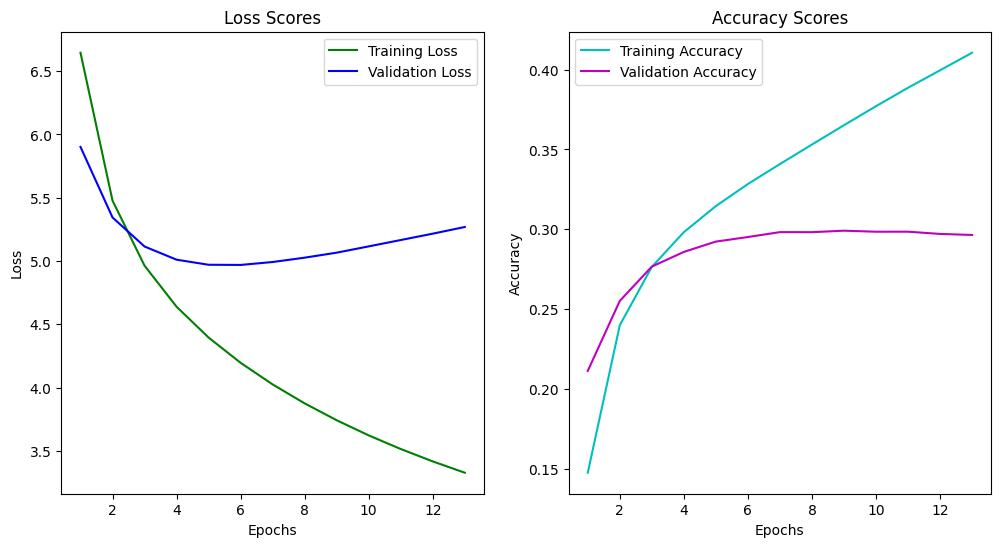

In [54]:
analyze_results_model(model_glove_10_results)

In [ ]:
seq2seq_glove_10 = load_model('/content/drive/MyDrive/machine_translation_models/seq2seq_glove_10.h5')

In [55]:
results = seq2seq_glove_10.evaluate([X_test, y_test[:, :-1]], y_test[:, 1:], batch_size=64)
print(results)

636/636 [==============================] - 14s 21ms/step - loss: 4.9679 - accuracy: 0.2954
[4.967854022979736, 0.29543256759643555]


In [56]:
print(f"Avg BLEU score for sentence size of 10 and 100 samples: {calculate_bleu_score(X_test, y_test, seq2seq_glove_10, tokenizer_target, sentence_length=10, samples_for_prediction=100)}")
print(f"Avg METEO score for sentence size of 10 and 100 sample: {calculate_meteor_score(X_test, y_test, seq2seq_glove_10, tokenizer_target, sentence_length=10, samples_for_prediction=100)}")

4/4 [==============================] - 0s 3ms/step
Avg BLEU score for sentence size of 10 and 100 samples: 0.050670975036482394
4/4 [==============================] - 0s 3ms/step
Avg METEO score for sentence size of 10 and 100 sample: 0.16215405834676236


**We saw some intriguing patterns in the model's performance as we evaluated it with different phrase lengths. At first, we tried out various lengths, varying from 27 to 10 tokens. Surprisingly, the BLEU and METEOR scores barely changed as a result of the duration change. When we trained the model on lengthier sentences with lengths of 50 and 70 tokens, the true impact became clear. As the sentence length increased, we noticed a decline in both BLEU and METEOR scores.**

#####<font color='blue'> 3) Seq2Seq model with FastText embedding and max_length = 10 </font>

In all other sections, we have used Glove Embedding technique for English language. However, just for this case, we will use fastText embedding to convert English words into vectors

In [ ]:
import zipfile
import os

def import_fasttext_embedding():
    """
    Downloads and extracts the English FastText embeddings.
    """

    # Set the path for the English FastText embeddings zip file
    zip_file_path = Path('/content/drive/MyDrive/FastText_embedding/wiki-news-300d-1M-subword.vec.zip')

    # Check if the embeddings zip file already exists in the target directory
    if zip_file_path.is_file():
        print('File already downloaded. Skipping download...')
        return
    else:
        # Create the directory for English FastText embeddings if it doesn't exist
        embedding_dir = '/content/drive/MyDrive/FastText_embedding/'
        os.makedirs(embedding_dir, exist_ok=True)

        print('Downloading English FastText embeddings...')
        !wget -P {embedding_dir} https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip

    # Check if the embeddings file is already extracted
    embedding_file_path = Path('/content/drive/MyDrive/FastText_embedding/wiki-news-300d-1M-subword.vec')
    if embedding_file_path.is_file():
        print('File already extracted. Skipping extraction...')
    else:
        # Extract the downloaded embeddings
        print('Extracting English FastText embeddings...')
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(embedding_dir)

    print('File Successfully downloaded and extracted')

# Call the function to download and extract the embeddings
import_fasttext_embedding()


--2023-07-28 19:37:02--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.248.124, 65.8.248.22, 65.8.248.107, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.248.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587879973 (561M) [application/zip]
Saving to: ‘/content/drive/MyDrive/FastText_embedding/wiki-news-300d-1M-subword.vec.zip’

wiki-news-300d-1M-s 100%[===================>] 560.65M  58.1MB/s    in 11s     

2023-07-28 19:37:13 (52.7 MB/s) - ‘/content/drive/MyDrive/FastText_embedding/wiki-news-300d-1M-subword.vec.zip’ saved [587879973/587879973]

Extracting English FastText embeddings...
File Successfully downloaded and extracted


In [57]:
#Create dictionary for english words (Using FastText Embedding)
fastext_eng_embeddings_dict = dict()
glove_file = open('/content/drive/MyDrive/FastText_embedding/wiki-news-300d-1M-subword.vec', 'r', encoding='utf-8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dim = np.asarray(records[1:], dtype='float32')
    fastext_eng_embeddings_dict[word] = vector_dim


#Create dictionary for bulgarian words
bg_embeddings_dict = dict()
bg_file = open('/content/drive/MyDrive/bulgarian_embedding/cc.bg.300.vec', encoding='utf-8')

for line in bg_file:
    records = line.strip().split()
    word = records[0]
    vector_dim = np.asarray(records[1:], dtype='float32')
    bg_embeddings_dict[word] = vector_dim

bg_file.close()

In [82]:
#Tokenize and padding
max_len = 10
encoder_padded, decoder_padded, max_length, tokenizer_input, tokenizer_target= tokenize_and_pad_sequences(en_dat, bg_dat, max_length=max_len)

#Word Embedding
encoder_embedding_matrix, decoder_embedding_matrix = word_embedding(fastext_eng_embeddings_dict, bg_embeddings_dict, tokenizer_input, tokenizer_target, embedding_dim=300)

# Splitting the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(encoder_padded, decoder_padded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [62]:
#Model Build
model_path = '/content/drive/MyDrive/machine_translation_models/seq2seq_fastext_embedd_model.h5'
fastext_embed_model, early_stopping, model_checkpoint = model_build(model_path, eng_vocab_size, bul_vocab_size,
                                                               encoder_embedding_matrix, decoder_embedding_matrix,
                                                               embed_dim=300, max_len=10, hid_unit=128,
                                                               change_target=False)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, None, 300)    23291400    ['input_16[0][0]']               
                                                                                                  
 lstm_15 (LSTM)                 (None, None, 128)    219648      ['embedding_15[0][0]']           
                                                                                                  
 input_15 (InputLayer)          [(None, 10)]         0           []                               
                                                                                            

In [63]:
fastext_model_results = fastext_embed_model.fit([X_train, y_train[:, :-1]], y_train[:, 1:], batch_size=64, epochs=20, validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2289/2289 [==============================] - 74s 31ms/step - loss: 6.6306 - accuracy: 0.1481 - val_loss: 5.8865 - val_accuracy: 0.2118
Epoch 2/20
2289/2289 [==============================] - 65s 28ms/step - loss: 5.4744 - accuracy: 0.2388 - val_loss: 5.3452 - val_accuracy: 0.2562
Epoch 3/20
2289/2289 [==============================] - 65s 28ms/step - loss: 4.9532 - accuracy: 0.2768 - val_loss: 5.1023 - val_accuracy: 0.2764
Epoch 4/20
2289/2289 [==============================] - 64s 28ms/step - loss: 4.6209 - accuracy: 0.2993 - val_loss: 4.9988 - val_accuracy: 0.2873
Epoch 5/20
2289/2289 [==============================] - 65s 28ms/step - loss: 4.3743 - accuracy: 0.3154 - val_loss: 4.9643 - val_accuracy: 0.2927
Epoch 6/20
2289/2289 [==============================] - 64s 28ms/step - loss: 4.1740 - accuracy: 0.3293 - val_loss: 4.9596 - val_accuracy: 0.2969
Epoch 7/20
2289/2289 [==============================] - 60s 26ms/step - loss: 4.0028 - accuracy: 0.3417 - val_loss: 4.9857 -

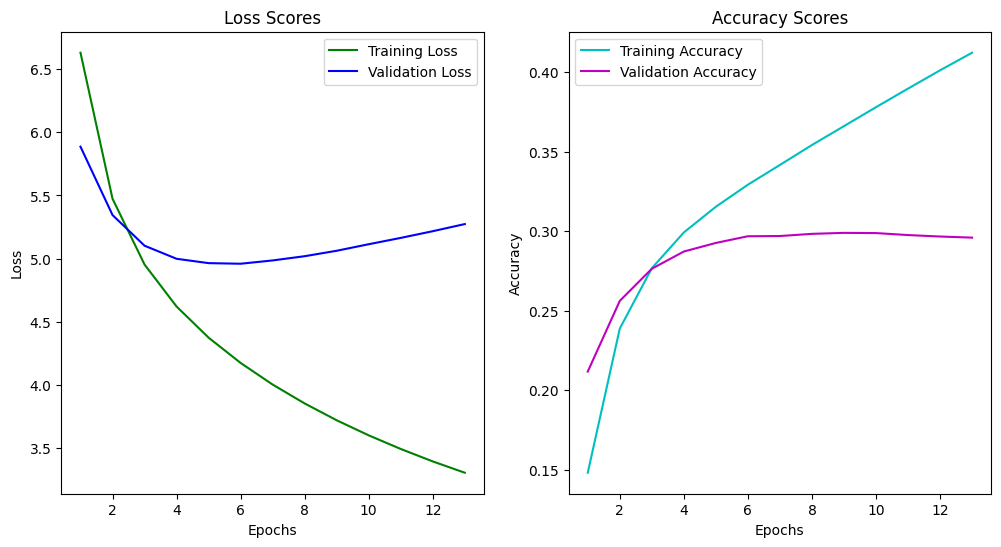

In [65]:
analyze_results_model(fastext_model_results)

In [ ]:
fastext_embed_model = load_model('/content/drive/MyDrive/machine_translation_models/seq2seq_fastext_embedd_model.h5')

In [66]:
results = fastext_embed_model.evaluate([X_test, y_test[:, :-1]], y_test[:, 1:], batch_size=64)
print(results)

636/636 [==============================] - 14s 21ms/step - loss: 4.9609 - accuracy: 0.2968
[4.960904121398926, 0.29677867889404297]


In [67]:
print(f"Avg BLEU score for sentence size of 10 and 100 samples: {calculate_bleu_score(X_test, y_test, fastext_embed_model, tokenizer_target, sentence_length=10, samples_for_prediction=100)}")
print(f"Avg METEO score for sentence size of 10 and 100 sample: {calculate_meteor_score(X_test, y_test, fastext_embed_model, tokenizer_target, sentence_length=10, samples_for_prediction=100)}")

4/4 [==============================] - 0s 3ms/step
Avg BLEU score for sentence size of 10 and 100 samples: 0.051449181675283805
4/4 [==============================] - 0s 3ms/step
Avg METEO score for sentence size of 10 and 100 sample: 0.16408481100416628


**Using FastText embedding instead of GloVe embedding had minimal impact on the overall model performance.**

#####<font color='blue'> 4) Change Input & Target Languages </font>


###### **Data Prep**

In [106]:
max_len = 10
encoder_padded, decoder_padded, max_length, tokenizer_input, tokenizer_target= tokenize_and_pad_sequences(en_dat, bg_dat, max_length=max_len)

#Word Embedding
encoder_embedding_matrix, decoder_embedding_matrix = word_embedding(eng_embeddings_dict, bg_embeddings_dict, tokenizer_input, tokenizer_target, embedding_dim=300)

In [107]:
##Padding for length = 10
X_train, X_test, y_train, y_test = train_test_split(encoder_padded, decoder_padded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

###### **Data Build**

In [108]:
model_path = '/content/drive/MyDrive/machine_translation_models/seq2seq_glove_reverse_model.h5'
reverse_model, early_stopping, model_checkpoint = model_build(model_path, eng_vocab_size, bul_vocab_size,
                                                               encoder_embedding_matrix, decoder_embedding_matrix,
                                                               embed_dim=300, max_len=10, hid_unit=128,
                                                               change_target=True)


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_33 (Embedding)       (None, None, 300)    23291400    ['input_34[0][0]']               
                                                                                                  
 lstm_33 (LSTM)                 (None, None, 128)    219648      ['embedding_33[0][0]']           
                                                                                                  
 input_33 (InputLayer)          [(None, 10)]         0           []                               
                                                                                           

###### **Data Train**

In [109]:
reverse_trained_model = reverse_model.fit([X_train, y_train[:, :-1]], y_train[:, 1:], batch_size=64, epochs=20, validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2289/2289 [==============================] - 74s 31ms/step - loss: 6.6325 - accuracy: 0.1482 - val_loss: 5.8984 - val_accuracy: 0.2118
Epoch 2/20
2289/2289 [==============================] - 65s 28ms/step - loss: 5.4780 - accuracy: 0.2392 - val_loss: 5.3413 - val_accuracy: 0.2562
Epoch 3/20
2289/2289 [==============================] - 65s 28ms/step - loss: 4.9504 - accuracy: 0.2775 - val_loss: 5.1007 - val_accuracy: 0.2774
Epoch 4/20
2289/2289 [==============================] - 65s 28ms/step - loss: 4.6205 - accuracy: 0.2997 - val_loss: 4.9966 - val_accuracy: 0.2872
Epoch 5/20
2289/2289 [==============================] - 65s 28ms/step - loss: 4.3759 - accuracy: 0.3163 - val_loss: 4.9574 - val_accuracy: 0.2934
Epoch 6/20
2289/2289 [==============================] - 65s 28ms/step - loss: 4.1761 - accuracy: 0.3304 - val_loss: 4.9560 - val_accuracy: 0.2972
Epoch 7/20
2289/2289 [==============================] - 60s 26ms/step - loss: 4.0054 - accuracy: 0.3433 - val_loss: 4.9767 -

###### **Data Evaluate**

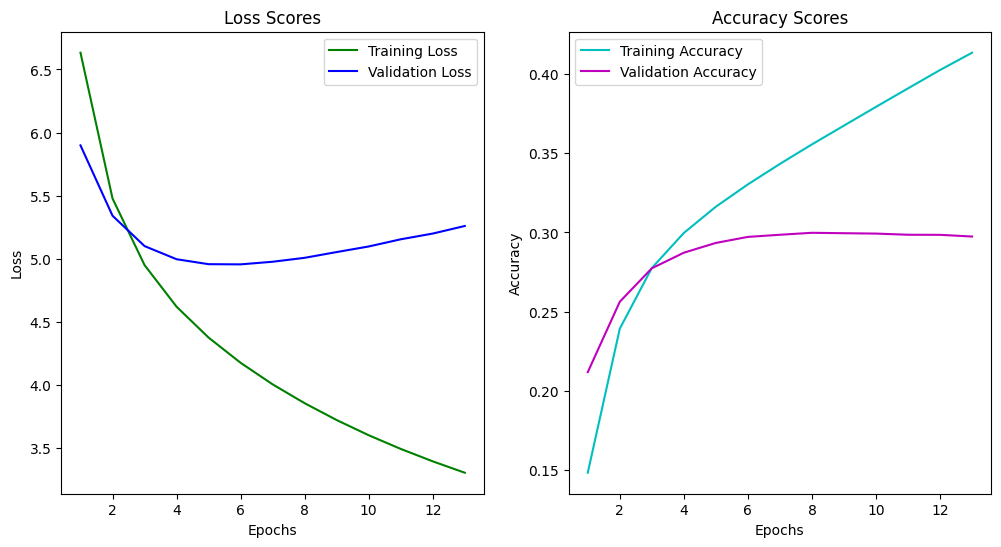

In [110]:
analyze_results_model(reverse_trained_model)

In [ ]:
reverse_model = load_model('/content/drive/MyDrive/machine_translation_models/seq2seq_glove_reverse_model.h5')

In [111]:
results = reverse_model.evaluate([X_test, y_test[:, :-1]], y_test[:, 1:], batch_size=64)
print(results)

636/636 [==============================] - 14s 22ms/step - loss: 4.9566 - accuracy: 0.2962
[4.956614971160889, 0.2961752414703369]


In [112]:
print(f"Avg BLEU score for sentence size of 10 and 100 sample: {calculate_bleu_score(X_test, y_test, reverse_model, tokenizer_target, sentence_length=10, samples_for_prediction=100)}")
print(f"Avg METEO score for sentence size of 10 and 100 sample: {calculate_meteor_score(X_test, y_test, reverse_model, tokenizer_target, sentence_length=10, samples_for_prediction=100)}")

4/4 [==============================] - 0s 3ms/step
Avg BLEU score for sentence size of 10 and 100 sample: 0.05448210088825811
4/4 [==============================] - 0s 3ms/step
Avg METEO score for sentence size of 10 and 100 sample: 0.1680360380990585


#####<font color='blue'> 5) Character Based Model</font>



In [ ]:
max_length = 10

#Character level tokenization
tokenizer_eng = Tokenizer(filters='', char_level=True)
tokenizer_eng.fit_on_texts(en_dat)
encoder_sequence = tokenizer_eng.texts_to_sequences(en_dat)


# Tokenize the Bulgarian data
tokenizer_bg = Tokenizer(filters='', char_level=True)
tokenizer_bg.fit_on_texts(bg_dat)
decoder_sequence = tokenizer_bg.texts_to_sequences(bg_dat)


encoder_padded = pad_sequences(encoder_sequence, maxlen=max_length, padding='post')
decoder_padded = pad_sequences(decoder_sequence, maxlen=max_length, padding='post')


#Check Vocab Size
eng_vocab_size = len(tokenizer_eng.word_index) + 1
bul_vocab_size = len(tokenizer_bg.word_index) + 1


#Word Embedding
encoder_embedding_matrix, decoder_embedding_matrix = word_embedding(eng_embeddings_dict, bg_embeddings_dict, tokenizer_eng, tokenizer_bg, embedding_dim=300)


## Data Split
X_train, X_test, y_train, y_test = train_test_split(encoder_padded, decoder_padded, test_size=0.2, random_state=42)

In [ ]:
model_path = '/content/drive/MyDrive/machine_translation_models/charac_model.h5'
charac_model, early_stopping, model_checkpoint = model_build(model_path, eng_vocab_size, bul_vocab_size,
                                                               encoder_embedding_matrix, decoder_embedding_matrix,
                                                               embed_dim=300, max_len=10, hid_unit=128,
                                                               change_target=False)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, None, 300)    48900       ['input_8[0][0]']                
                                                                                                  
 lstm_7 (LSTM)                  (None, None, 128)    219648      ['embedding_7[0][0]']            
                                                                                                  
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                            

In [ ]:
charac_model_results = charac_model.fit([X_train, y_train[:, :-1]], y_train[:, 1:], batch_size=64, epochs=20, validation_data=([X_test, y_test[:, :-1]], y_test[:, 1:]), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2544/2544 [==============================] - 21s 8ms/step - loss: 1.9097 - accuracy: 0.4450 - val_loss: 1.5270 - val_accuracy: 0.5563
Epoch 2/20
2544/2544 [==============================] - 16s 6ms/step - loss: 1.4017 - accuracy: 0.5917 - val_loss: 1.3256 - val_accuracy: 0.6163
Epoch 3/20
2544/2544 [==============================] - 15s 6ms/step - loss: 1.2698 - accuracy: 0.6293 - val_loss: 1.2435 - val_accuracy: 0.6368
Epoch 4/20
2544/2544 [==============================] - 15s 6ms/step - loss: 1.2050 - accuracy: 0.6473 - val_loss: 1.1973 - val_accuracy: 0.6511
Epoch 5/20
2544/2544 [==============================] - 15s 6ms/step - loss: 1.1649 - accuracy: 0.6578 - val_loss: 1.1704 - val_accuracy: 0.6577
Epoch 6/20
2544/2544 [==============================] - 15s 6ms/step - loss: 1.1366 - accuracy: 0.6652 - val_loss: 1.1471 - val_accuracy: 0.6649
Epoch 7/20
2544/2544 [==============================] - 15s 6ms/step - loss: 1.1146 - accuracy: 0.6710 - val_loss: 1.1330 - val_ac

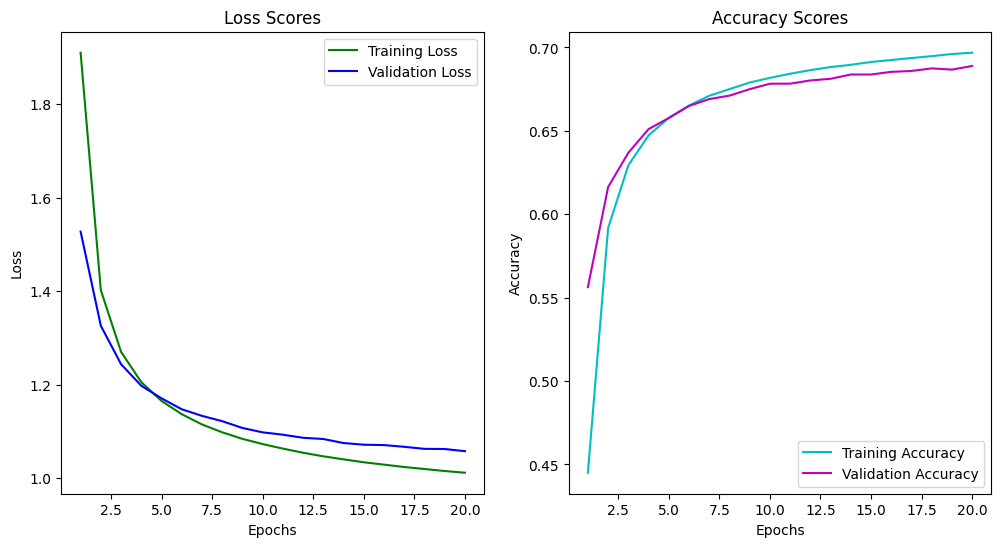

In [ ]:
#Result Visualization
analyze_results_model(charac_model_results)

In [ ]:
charac_model = load_model('/content/drive/MyDrive/machine_translation_models/charac_model.h5')

In [ ]:
results = charac_model.evaluate([X_test, y_test[:, :-1]], y_test[:, 1:], batch_size=64)
print(results)

636/636 [==============================] - 3s 3ms/step - loss: 1.0575 - accuracy: 0.6889
[1.0574500560760498, 0.6888730525970459]


In [ ]:
print(f"Avg BLEU score for sentence size of 10 and 100 sample: {calculate_bleu_score(X_test, y_test, charac_model, tokenizer_bg, sentence_length=10, samples_for_prediction=100)}")
print(f"Avg METEO score for sentence size of 10 and 100 sample: {calculate_meteor_score(X_test, y_test, charac_model, tokenizer_bg, sentence_length=10, samples_for_prediction=100)}")

4/4 [==============================] - 0s 4ms/step
Reference Translation Example:   и   о т б р а н а

Predicted Translation Example: п   п т   р а н а х

Avg BLEU score for sentence size of 10 and 100 sample: 0.43570593428674537
4/4 [==============================] - 0s 3ms/step
Avg METEO score for sentence size of 10 and 100 sample: 0.5916186020103688


**Our model performs significantly better when using a character-based approach compared to a sentence-based one. The character-based model shows remarkable improvement in BLEU and METEOR scores<br>**

**However, this improved performance does not guarantee overall superiority. The character-based model excels with smaller sentence lengths, but its effectiveness may diminish as the sentence length increases. Additionally, predicting at the character level does not ensure coherent and meaningful sentences.<br>**

**Therefore, while the character-based model shows promise for certain scenarios, its limitations should be carefully considered when dealing with longer and more complex text sequences.<br>**

## Task 4: Neural Machine Translation with Attention

1) https://www.youtube.com/watch?v=B3uws4cLcFw<br>
2) https://medium.com/data-science-community-srm/understanding-encoders-decoders-with-attention-based-mechanism-c1eb7164c581<br>
3) https://www.youtube.com/watch?v=BSSoEtv5jvQ&list=PLmZlBIcArwhPHmHzyM_cZJQ8_v5paQJTV&index=6

In [ ]:
##Padding for length = 10
max_len = 10
encoder_padded, decoder_padded, max_length, tokenizer_input, tokenizer_target= tokenize_and_pad_sequences(en_dat, bg_dat, max_length=max_len)

#Create weight matrix
encoder_embedding_matrix, decoder_embedding_matrix = word_embedding(eng_embeddings_dict, bg_embeddings_dict, tokenizer_input, tokenizer_target, embedding_dim=300)

#Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(encoder_padded, decoder_padded, test_size=0.2, random_state=42)

#Vocab size
eng_vocab_size = vocabulary_size(tokenizer_input)
bul_vocab_size = vocabulary_size(tokenizer_target)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
import tensorflow as tf

## Taken from the following link: https://www.tensorflow.org/text/tutorials/nmt_with_attention#the_encoderdecoder
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [ ]:
def seq2seq_attention(input_vocab_size, output_vocab_size, encoder_embedding_matrix, decoder_embedding_matrix,
                      embedding_dim=300, max_length=25, hidden_units=128, change_targets=False,
                      dropout_rate=0.2):

    # Encoder
    encoder_inputs = Input(shape=(max_length,))
    encoder_embedding = Embedding(input_vocab_size, embedding_dim, weights=[encoder_embedding_matrix],
                                  input_length=max_length, mask_zero=True)(encoder_inputs)
    encoder_lstm = LSTM(hidden_units, return_sequences=True)(encoder_embedding)
    encoder_lstm = Dropout(dropout_rate)(encoder_lstm)  # Add dropout regularization

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, embedding_dim, weights=[decoder_embedding_matrix])(decoder_inputs)
    decoder_lstm = LSTM(hidden_units, return_sequences=True)(decoder_embedding)
    decoder_lstm = Dropout(dropout_rate)(decoder_lstm)  # Add dropout regularization

    # Attention
    cross_attention = CrossAttention(units=hidden_units)
    decoder_attention = cross_attention(decoder_lstm, encoder_lstm)  # Pass query and context explicitly

    # Output layer
    decoder_outputs = Dense(output_vocab_size, activation='softmax')(decoder_attention)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model


In [ ]:
def seq2seq_attention_model(model_store_path, eng_vocab_size, bul_vocab_size, encoder_embedding_matrix, decoder_embedding_matrix,
                embed_dim=300, max_len=25, hid_unit=128, change_target=False, dropout_rat=0.2):

  # Set up early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

  # Set up model checkpoint callback to save the best model
  model_checkpoint = ModelCheckpoint(filepath=model_store_path, monitor='val_loss', save_best_only=True)
  model = seq2seq_attention(eng_vocab_size, bul_vocab_size, encoder_embedding_matrix, decoder_embedding_matrix, embedding_dim=embed_dim, max_length=max_len, hidden_units=hid_unit, change_targets=change_target, dropout_rate=dropout_rat)

  model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'],


            )

  model.summary()

  return model, early_stopping, model_checkpoint

In [ ]:
model_path = '/content/drive/MyDrive/machine_translation_models/seq2seq_attention_model.h5'
seq2seq_att_model, early_stopping, model_checkpoint = seq2seq_attention_model(model_path, eng_vocab_size, bul_vocab_size,
                                                               encoder_embedding_matrix, decoder_embedding_matrix,
                                                               embed_dim=300, max_len=10, hid_unit=128,
                                                               change_target=False, dropout_rat=0.2)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_47 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 embedding_47 (Embedding)       (None, None, 300)    23291400    ['input_48[0][0]']               
                                                                                                  
 embedding_46 (Embedding)       (None, 10, 300)      11682000    ['input_47[0][0]']               
                                                                                           

In [ ]:
seq2seq_att_model_results = seq2seq_att_model.fit([X_train, y_train[:, :-1]], y_train[:, 1:], batch_size=64, epochs=20, validation_split=0.1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2289/2289 [==============================] - 129s 52ms/step - loss: 4.8874 - accuracy: 0.3187 - val_loss: 3.3742 - val_accuracy: 0.4691
Epoch 2/20
2289/2289 [==============================] - 98s 43ms/step - loss: 2.9516 - accuracy: 0.4973 - val_loss: 2.9148 - val_accuracy: 0.5202
Epoch 3/20
2289/2289 [==============================] - 97s 42ms/step - loss: 2.3569 - accuracy: 0.5532 - val_loss: 2.8170 - val_accuracy: 0.5374
Epoch 4/20
2289/2289 [==============================] - 94s 41ms/step - loss: 2.0021 - accuracy: 0.5921 - val_loss: 2.8317 - val_accuracy: 0.5420
Epoch 5/20
2289/2289 [==============================] - 94s 41ms/step - loss: 1.7533 - accuracy: 0.6270 - val_loss: 2.8880 - val_accuracy: 0.5435
Epoch 6/20
2289/2289 [==============================] - 94s 41ms/step - loss: 1.5795 - accuracy: 0.6539 - val_loss: 2.9411 - val_accuracy: 0.5440
Epoch 7/20
2289/2289 [==============================] - 94s 41ms/step - loss: 1.4515 - accuracy: 0.6753 - val_loss: 2.9983 

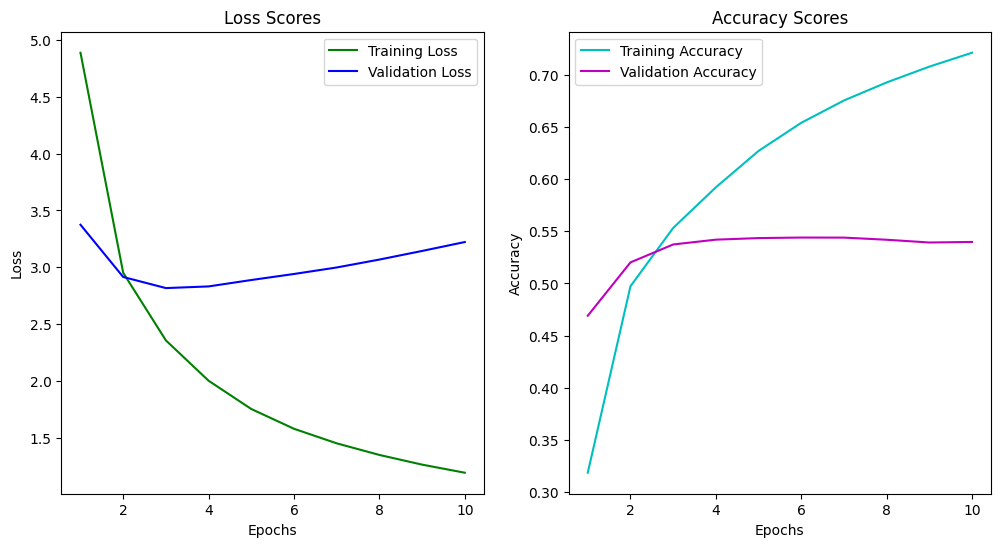

In [ ]:
analyze_results_model(seq2seq_att_model_results)

In [ ]:
results = seq2seq_att_model.evaluate([X_test, y_test[:, :-1]], y_test[:, 1:], batch_size=64)
print(results)

636/636 [==============================] - 18s 29ms/step - loss: 2.8055 - accuracy: 0.5385
[2.805523633956909, 0.5384714007377625]


In [ ]:
print(f"Avg BLEU score for sentence size of 10 and 100 sample: {calculate_bleu_score(X_test, y_test, seq2seq_att_model, tokenizer_target, sentence_length=10, samples_for_prediction=100)}")
print(f"Avg METEO score for sentence size of 10 and 100 sample: {calculate_meteor_score(X_test, y_test, seq2seq_att_model, tokenizer_target, sentence_length=10, samples_for_prediction=100)}")

4/4 [==============================] - 2s 5ms/step
Reference Translation Example: фактор за укрепване на европейската политика за сигурност и отбрана

Predicted Translation Example: за укрепване на европейската сигурност и сигурност и отбрана епсо

Avg BLEU score for sentence size of 10 and 100 sample: 0.1631596176030577
4/4 [==============================] - 0s 5ms/step
Avg METEO score for sentence size of 10 and 100 sample: 0.38596304750471616


**From the results presented above, it is evident that incorporating an attention layer into the RNN model has led to significantly better performance compared to our previous attempt with a simple RNN network. The attention mechanism allows the model to focus on relevant parts of the input sequence, which enhances its ability to capture important patterns and dependencies.**<br>

**However, it is worth noting that to fully exploit the potential of the attention layer, a substantial amount of training data is usually required. In our case, due to GPU costs, we were only able to utilize 50% of the available data during training, limiting the model's exposure to valuable information.**<br>

**Despite this limitation, there are promising avenues for further improvement. Fine-tuning the model by adjusting hyperparameters, experimenting with different architectures, and, most importantly, utilizing the complete dataset can undoubtedly lead to even better results. Having access to the entire dataset will provide the model with a more comprehensive understanding of the underlying patterns and relationships, enabling it to perform at its full potential.**<br>

**In conclusion, our initial experimentation with an attention-based RNN model has yielded impressive results, and with the right adjustments and access to the complete dataset, we can further enhance its performance and achieve even more accurate and reliable predictions.**<br>